In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics

color = sns.color_palette()

In [ ]:
!pip install xgboost
!pip install lightgbm
!pip install pandas
!pip install matplotlib
!pip install seaborn



In [4]:
#PATH_TO_FILE = "/kaggle/input/psykose/schizophrenia-features.csv"
PATH_TO_FILE = "../../psykose/schizophrenia-features.csv"


_PARAMS_LORGREG = {
    "penalty": "l2", "C": 1.0, "class_weight": "balanced",
    "random_state": 2018, "solver": "liblinear", "n_jobs": 1
}

_PARAMS_RFC = {
    "n_estimators": 10,
    "max_features": "auto", "max_depth": None,
    "min_samples_split": 2, "min_samples_leaf": 1,
    "min_weight_fraction_leaf": 0.0,
    "max_leaf_nodes": None, "bootstrap": True,
    "oob_score": False, "n_jobs": -1, "random_state": 2018,
    "class_weight": "balanced"
}

_PARAMS_XGB = {
    "nthread":16, "learning_rate": 0.3, "gamma": 0, "max_depth": 6, "verbosity": 0,
    "min_child_weight": 1, "max_delta_step": 0, "subsample": 1.0, "colsample_bytree": 1.0,
    "objective":"binary:logistic", "num_class":1, "eval_metric":"logloss", "seed":2018,
}

_PARAMS_LIGHTGB = {
    "task": "train", "num_class":1, "boosting": "gbdt", "verbosity": -1,
    "objective": "binary", "metric": "binary_logloss", "metric_freq":50, "is_training_metric":False,
    "max_depth":4, "num_leaves": 31, "learning_rate": 0.01, "feature_fraction": 1.0, "bagging_fraction": 1.0,
    "bagging_freq": 0, "bagging_seed": 2018, "num_threads":16
}

In [5]:
data = pd.read_csv(PATH_TO_FILE)

dataX = data.copy().drop(["class", "class_str", "userid"], axis=1)
dataY = data["class"].copy()

scaler = pp.StandardScaler(copy=True)

dataX.loc[:, dataX.columns] = scaler.fit_transform(dataX[dataX.columns])

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(
    dataX,
    dataY,
    test_size=0.10,
    random_state=2019,
    stratify=dataY
)

In [6]:
def plot_prc_curve(y_preds, y_trues, title=None):
    
    precision, recall, _ = metrics.precision_recall_curve(
        y_trues,
        y_preds
    )

    average_precision = metrics.average_precision_score(
        y_trues,
        y_preds
    )

    print("Average Precision = %.2f" % average_precision)
    
    plt.step(recall, precision, color="k", alpha=0.7, where="post")
    plt.fill_between(recall, precision, step="post", alpha=0.3, color="k")

    if title is None:
        title = "PRC: Average Precision = %.2f" % average_precision

    plt.title(title)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

    plt.show()

def plot_roc_curve(y_preds, y_trues, title=None):
    
    fpr, tpr, _ = metrics.roc_curve(y_trues, y_preds)

    auc_roc = metrics.auc(fpr, tpr)

    print("AUCROC = %.2f" % auc_roc)

    if title is None:
        title = "AUCROC = %.2f" % auc_roc

    plt.title(title)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    
    plt.plot(fpr, tpr, color="r", lw=2, label="ROC curve")
    plt.plot([0, 1], [0, 1], color="k", lw=2, linestyle="--")

    plt.show()


def model_predict_k_fold( train_func, pred_func, model=None, n_splits=10, shuffle=True, random_state=2018 ):
     
    y_preds = []
    y_trues = []

    k_fold = StratifiedKFold(
        n_splits=n_splits,
        shuffle=shuffle,
        random_state=random_state
    )

    for train_index, fold_index in k_fold.split(np.zeros(len(X_TRAIN)), Y_TRAIN.ravel()):
        
        x_fold_train, x_fold_test = X_TRAIN.iloc[train_index, :], X_TRAIN.iloc[fold_index, :]
        y_fold_train, y_fold_test = Y_TRAIN.iloc[train_index], Y_TRAIN.iloc[fold_index]

        model = train_func( model, x_fold_train, y_fold_train, x_fold_test, y_fold_test )
        y_pred = pred_func( model, x_fold_test )

        y_preds.extend( list(y_pred) )
        y_trues.extend( list(y_fold_test) )

    return model, np.array(y_preds), np.array(y_trues)


# Logistic Regression

Average Precision = 0.91


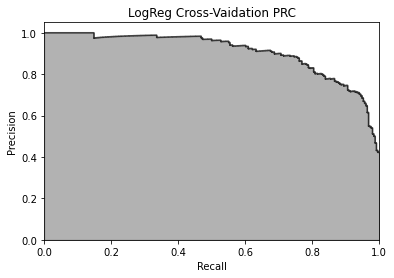

AUCROC = 0.92


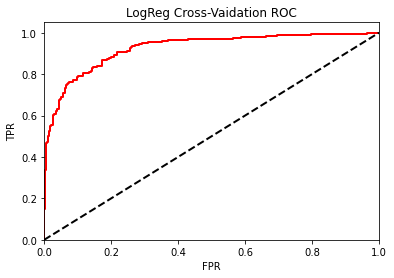

Average Precision = 0.81


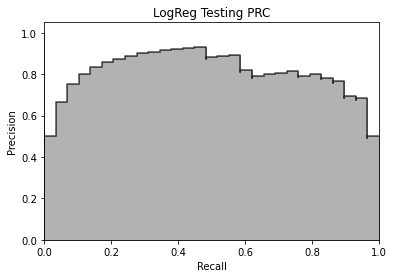

AUCROC = 0.89


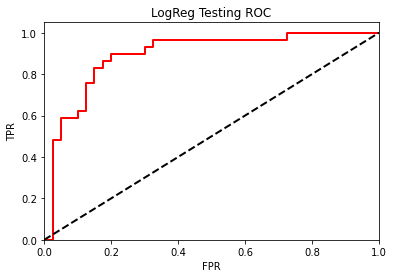

In [7]:
def logreg_train_func(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    return model

def logreg_pred_func(model, data):
    return model.predict_proba(data)[:, 1]

logreg = LogisticRegression( **_PARAMS_LORGREG )

logreg, logreg_y_preds, logreg_y_trues = model_predict_k_fold( logreg_train_func, logreg_pred_func, logreg )
logreg_test_preds = logreg_pred_func( logreg, X_TEST )

plot_prc_curve( logreg_y_preds, logreg_y_trues, "LogReg Cross-Vaidation PRC" )
plot_roc_curve( logreg_y_preds, logreg_y_trues, "LogReg Cross-Vaidation ROC" )

plot_prc_curve( logreg_test_preds, Y_TEST, "LogReg Testing PRC" )
plot_roc_curve( logreg_test_preds, Y_TEST, "LogReg Testing ROC" )

# Random Forest

Average Precision = 0.87


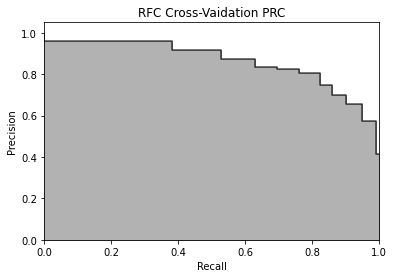

AUCROC = 0.91


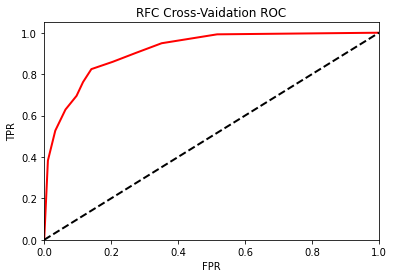

Average Precision = 0.79


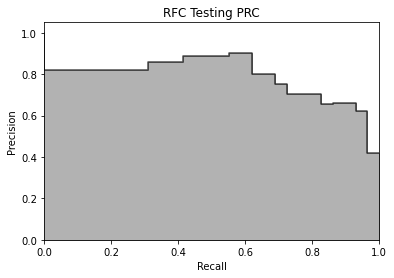

AUCROC = 0.87


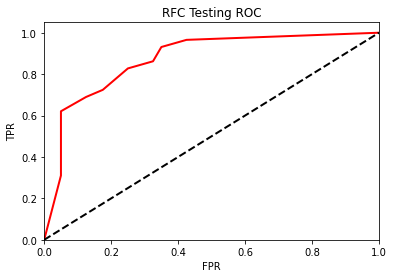

In [8]:
def rfc_train_func(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    return model

def rfc_pred_func(model, data):
    return model.predict_proba(data)[:, 1]

rfc = RandomForestClassifier( **_PARAMS_RFC )

rfc, rfc_y_preds, rfc_y_trues = model_predict_k_fold( rfc_train_func, rfc_pred_func, rfc )
rfc_test_preds = rfc_pred_func( rfc, X_TEST )

plot_prc_curve( rfc_y_preds, rfc_y_trues, "RFC Cross-Vaidation PRC" )
plot_roc_curve( rfc_y_preds, rfc_y_trues, "RFC Cross-Vaidation ROC" )

plot_prc_curve( rfc_test_preds, Y_TEST, "RFC Testing PRC" )
plot_roc_curve( rfc_test_preds, Y_TEST, "RFC Testing ROC" )

# XGBoost

[0]	train-logloss:0.51743+0.00617	test-logloss:0.55621+0.01134
[50]	train-logloss:0.05264+0.00417	test-logloss:0.40863+0.09775
[100]	train-logloss:0.03095+0.00202	test-logloss:0.44715+0.11357
[150]	train-logloss:0.02334+0.00122	test-logloss:0.47394+0.12256
[200]	train-logloss:0.01971+0.00088	test-logloss:0.48668+0.12567
[212]	train-logloss:0.01910+0.00084	test-logloss:0.48987+0.12705
[0]	train-logloss:0.52083+0.00337	test-logloss:0.55909+0.00681
[50]	train-logloss:0.06471+0.00192	test-logloss:0.45936+0.04319
[100]	train-logloss:0.03633+0.00150	test-logloss:0.50428+0.04883
[150]	train-logloss:0.02683+0.00131	test-logloss:0.53198+0.05591
[200]	train-logloss:0.02239+0.00111	test-logloss:0.55654+0.06344
[207]	train-logloss:0.02196+0.00108	test-logloss:0.56017+0.06417
[0]	train-logloss:0.52286+0.00544	test-logloss:0.55863+0.01267
[50]	train-logloss:0.06262+0.00430	test-logloss:0.44822+0.07962
[100]	train-logloss:0.03598+0.00238	test-logloss:0.49285+0.09696
[150]	train-logloss:0.02653+0.0016

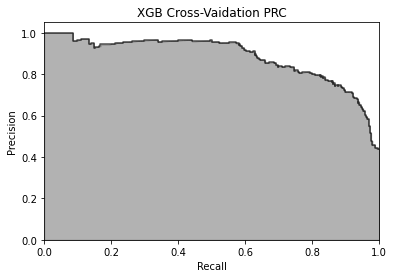

AUCROC = 0.91


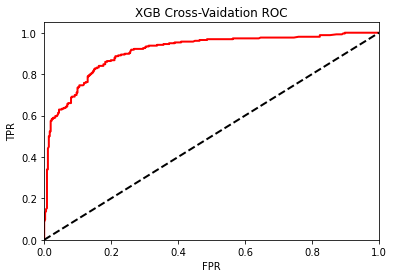

Average Precision = 0.84


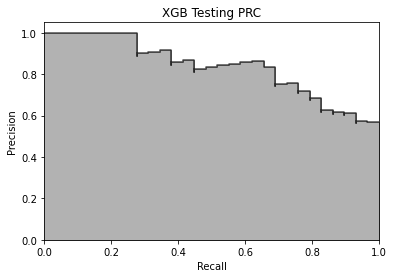

AUCROC = 0.87


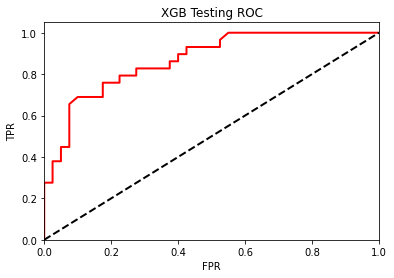

In [9]:
def xgb_train_func(model, x_train, y_train, x_test, y_test):
    dtrain = xgb.DMatrix(data=x_train, label=y_train)

    bst = xgb.cv(_PARAMS_XGB,
        dtrain,
        num_boost_round=2000,
        nfold=5,
        early_stopping_rounds=200,
        verbose_eval=50
    )

    best_rounds = np.argmin(bst["test-logloss-mean"])
    bst = xgb.train(_PARAMS_XGB, dtrain, best_rounds)
    return bst

def xgb_pred_func(model, data):
    data = xgb.DMatrix(data=data)
    pred = model.predict(data)
    return pred

xgb_model, xgb_y_preds, xgb_y_trues = model_predict_k_fold( xgb_train_func, xgb_pred_func )
xgb_test_preds = xgb_pred_func( xgb_model, X_TEST )

plot_prc_curve( xgb_y_preds, xgb_y_trues, "XGB Cross-Vaidation PRC" )
plot_roc_curve( xgb_y_preds, xgb_y_trues, "XGB Cross-Vaidation ROC" )

plot_prc_curve( xgb_test_preds, Y_TEST, "XGB Testing PRC" )
plot_roc_curve( xgb_test_preds, Y_TEST, "XGB Testing ROC" )

# LightGBM

/Users/fellipeferreira/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/fellipeferreira/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Average Precision = 0.91


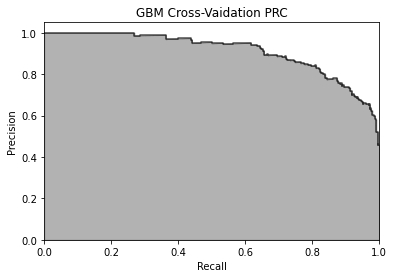

AUCROC = 0.93


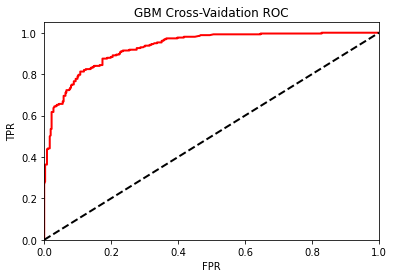

Average Precision = 0.84


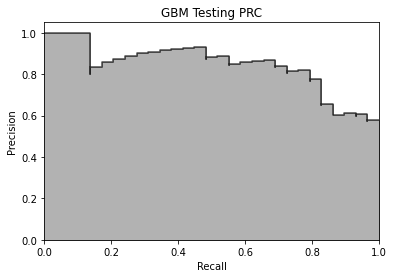

AUCROC = 0.89


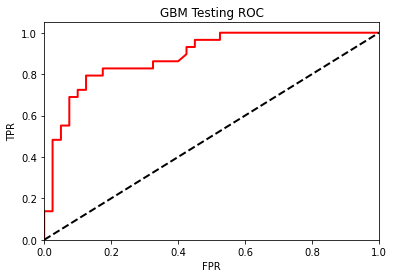

In [10]:
def gbm_train_func(model, x_train, y_train, x_test, y_test):
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

    gbm = lgb.train(
        _PARAMS_LIGHTGB,
        lgb_train,
        verbose_eval=False,
        num_boost_round=2000,
        valid_sets=lgb_eval,
        early_stopping_rounds=200
    )

    return gbm

def gbm_pred_func(model, data):
    return model.predict(data, num_iteration=model.best_iteration)

gbm, gbm_y_preds, gbm_y_trues = model_predict_k_fold( gbm_train_func, gbm_pred_func )
gbm_test_preds = gbm_pred_func( gbm, X_TEST )

plot_prc_curve( gbm_y_preds, gbm_y_trues, "GBM Cross-Vaidation PRC" )
plot_roc_curve( gbm_y_preds, gbm_y_trues, "GBM Cross-Vaidation ROC" )

plot_prc_curve( gbm_test_preds, Y_TEST, "GBM Testing PRC" )
plot_roc_curve( gbm_test_preds, Y_TEST, "GBM Testing ROC" )

# Ensemble

/Users/fellipeferreira/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/fellipeferreira/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Average Precision = 0.91


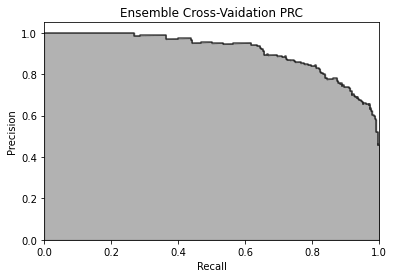

AUCROC = 0.93


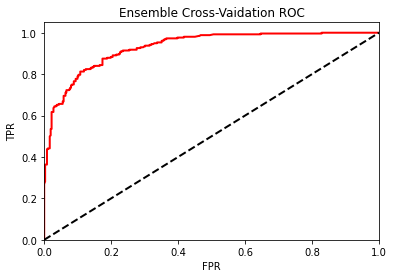

Average Precision = 0.84


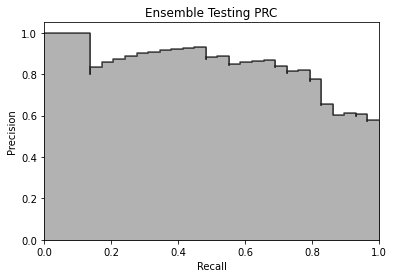

AUCROC = 0.89


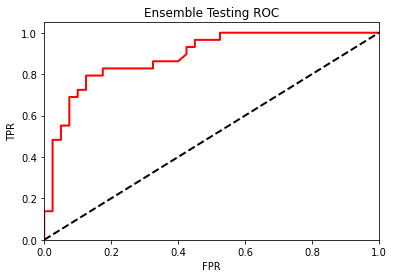

In [11]:
def ensemble_train_func(model, x_train, y_train, x_test, y_test):
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

    ensemble = lgb.train(
        _PARAMS_LIGHTGB,
        lgb_train,
        verbose_eval=False,
        num_boost_round=2000,
        valid_sets=lgb_eval,
        early_stopping_rounds=200
    )

    return ensemble

def ensemble_pred_func(model, data):
    return model.predict(data, num_iteration=model.best_iteration)

ensemble, ensemble_y_preds, ensemble_y_trues = model_predict_k_fold( ensemble_train_func, ensemble_pred_func )
ensemble_test_preds = ensemble_pred_func( ensemble, X_TEST )

plot_prc_curve( ensemble_y_preds, ensemble_y_trues, "Ensemble Cross-Vaidation PRC" )
plot_roc_curve( ensemble_y_preds, ensemble_y_trues, "Ensemble Cross-Vaidation ROC" )

plot_prc_curve( ensemble_test_preds, Y_TEST, "Ensemble Testing PRC" )
plot_roc_curve( ensemble_test_preds, Y_TEST, "Ensemble Testing ROC" )